<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/2-Advance/FinRL_Ensemble_StockTrading_ICAIF_2020.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading Using Ensemble Strategy

Tutorials to use OpenAI DRL to trade multiple stocks using ensemble strategy in one Jupyter Notebook | Presented at ICAIF 2020

* This notebook is the reimplementation of our paper: Deep Reinforcement Learning for Automated Stock Trading: An Ensemble Strategy, using FinRL.
* Check out medium blog for detailed explanations: https://medium.com/@ai4finance/deep-reinforcement-learning-for-automated-stock-trading-f1dad0126a02
* Please report any issues to our Github: https://github.com/AI4Finance-LLC/FinRL-Library/issues
* **Pytorch Version**



# Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. Check Additional Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
* [5.Build Environment](#4)  
    * [5.1. Training & Trade Data Split](#4.1)
    * [5.2. User-defined Environment](#4.2)   
    * [5.3. Initialize Environment](#4.3)    
* [6.Implement DRL Algorithms](#5)  
* [7.Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
    * [7.3. Baseline Stats](#6.3)   
    * [7.3. Compare to Stock Market Index](#6.4)             

<a id='0'></a>
# Part 1. Problem Definition

This problem is to design an automated trading solution for single stock trading. We model the stock trading process as a Markov Decision Process (MDP). We then formulate our trading goal as a maximization problem.

The algorithm is trained using Deep Reinforcement Learning (DRL) algorithms and the components of the reinforcement learning environment are:


* Action: The action space describes the allowed actions that the agent interacts with the
environment. Normally, a ∈ A includes three actions: a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying one stock. Also, an action can be carried upon multiple shares. We use
an action space {−k, ..., −1, 0, 1, ..., k}, where k denotes the number of shares. For example, "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* Reward function: r(s, a, s′) is the incentive mechanism for an agent to learn a better action. The change of the portfolio value when action a is taken at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio
values at state s′ and s, respectively

* State: The state space describes the observations that the agent receives from the environment. Just as a human trader needs to analyze various information before executing a trade, so
our trading agent observes many different features to better learn in an interactive environment.

* Environment: Dow 30 consituents


The data of the single stock that we will be using for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import importlib
from pathlib import Path

from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor import fixed_yahoodownloader # comment this if you chose other path above
importlib.reload(fixed_yahoodownloader) # comment this if you chose other path above
from finrl.meta.preprocessor.fixed_yahoodownloader import YahooDownloader #comment this if you chose the other path above

from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

<a id='1.4'></a>
## 2 Create Folders

In [4]:
from pathlib import Path
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    # INDICATORS,
    # TRAIN_START_DATE,
    # TRAIN_END_DATE,
    # TEST_START_DATE,
    # TEST_END_DATE,
)

print(DATA_SAVE_DIR)

for directory in [DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR]:
    Path(directory).mkdir(parents=True, exist_ok=True)

datasets


In [5]:
# overwriting configs
INDICATORS = ['macd',
        'rsi_30',
        'cci_30',
        'dx_30']

TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2021-10-01'
TEST_START_DATE = '2021-10-01'
TEST_END_DATE = '2024-03-01'

print(DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** to fetch data from Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).




-----
class YahooDownloader:
    Provides methods for retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data (modified from config.py)
        end_date : str
            end date of the data (modified from config.py)
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()
        Fetches data from yahoo API


In [6]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (104573, 8)
Display DataFrame:           date      close       high        low       open    volume  tic  day
0  2010-01-04  32.906189  41.099998  40.389999  40.810001   6894300  AXP    0
1  2010-01-05  32.833797  41.230000  40.369999  40.830002  10641200  AXP    1
2  2010-01-06  33.364548  41.669998  41.169998  41.230000   8399400  AXP    2
3  2010-01-07  33.905678  42.240002  41.110001  41.259998   8981700  AXP    3
4  2010-01-08  33.881470  42.480000  41.400002  41.759998   7907700  AXP    4


# Part 4: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.
* Add technical indicators. In practical trading, various information needs to be taken into account, for example the historical stock prices, current holding shares, technical indicators, etc. In this article, we demonstrate two trend-following technical indicators: MACD and RSI.
* Add turbulence index. Risk-aversion reflects whether an investor will choose to preserve the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the financial turbulence index that measures extreme asset price fluctuation.

In [7]:
def preprocess_dataframe(df):
    fe = FeatureEngineer(use_technical_indicator=True,
                            tech_indicator_list = INDICATORS,
                            use_turbulence=True,
                            user_defined_feature = False)

    processed = fe.preprocess_data(df)
    processed = processed.copy()
    processed = processed.fillna(0)
    processed = processed.replace(np.inf,0)
    return processed

processed = preprocess_dataframe(df)

KeyboardInterrupt: 

<a id='4'></a>
# Part 5. Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a **Markov Decision Process (MDP)** problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [ ]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 175


In [ ]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "reward_scaling": 1e-4,
    "state_space": state_space,
    "action_space": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "print_verbosity":5
}

rebalance_window = 63
validation_window = 63

<a id='5'></a>
# Part 6: Implement DRL Algorithms
* The implementation of the DRL algorithms are based on **OpenAI Baselines** and **Stable Baselines**. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

* The paper trains and validates 3 model-free agents (A2C, PPO, DDPG) using Rolling-Window Ensemble Method ([reference code](https://github.com/AI4Finance-LLC/Deep-Reinforcement-Learning-for-Automated-Stock-Trading-Ensemble-Strategy-ICAIF-2020/blob/80415db8fa7b2179df6bd7e81ce4fe8dbf913806/model/models.py#L92))

* We train and validate 2 model-based agents (Random Shooting and PETS) using the sam Rolling-Window method without Ensembling.

In [ ]:
from finrl.agents.stablebaselines3.pets_model import PETSAgent
from finrl.agents.stablebaselines3.pets_no_ensemble_model import PETS_NO_ENSEMBLEAgent

In [ ]:
model_names = ["PETS", "PETS_NO_ENSEMBLE"]
models = {}
df_summaries = {}

In [ ]:
pets_params = {
    "hidden_dim": 64,
    "lr": 1e-4,
    "epochs": 100,
    "horizon": 10,
}

# The reason we need two file and two class is due to the bad modularization of the original code
models["PETS"] = PETSAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs,
                 **pets_params,
                 ensemble_size=5)

models["PETS_NO_ENSEMBLE"]  = PETS_NO_ENSEMBLEAgent(df=processed,
                    train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                    val_test_period=(TEST_START_DATE,TEST_END_DATE),
                    rebalance_window=rebalance_window,
                    validation_window=validation_window,
                    **env_kwargs,
                    **pets_params,
                    ensemble_size=1)

In [ ]:
for model_name, model in models.items():
    df_summaries[model_name] = model.run_strategy(10000)

============Start PETS Strategy============
turbulence_threshold:  201.71769741531372
======Model training from:  2010-01-01 to  2021-10-04
======PETS Training (PETS)========
======PETS Validation from:  2021-10-04 to  2022-01-03
PETS Sharpe Ratio:  0.04936532490721564
======Trading from:  2022-01-03 to  2022-04-04
turbulence_threshold:  201.71769741531372
======Model training from:  2010-01-01 to  2022-01-03
======PETS Training (PETS)========
======PETS Validation from:  2022-01-03 to  2022-04-04
PETS Sharpe Ratio:  -0.7640014574380805
======Trading from:  2022-04-04 to  2022-07-06
turbulence_threshold:  201.71769741531372
======Model training from:  2010-01-01 to  2022-04-04
======PETS Training (PETS)========
======PETS Validation from:  2022-04-04 to  2022-07-06
PETS Sharpe Ratio:  -1.021871745978309
======Trading from:  2022-07-06 to  2022-10-04
turbulence_threshold:  201.71769741531372
======Model training from:  2010-01-01 to  2022-07-06
======PETS Training (PETS)========
======P

<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [22]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

Reading account value data for PETS at 126th trade date at results/account_value_trade_PETS_126.csv
Reading account value data for PETS at 189th trade date at results/account_value_trade_PETS_189.csv
Reading account value data for PETS at 252th trade date at results/account_value_trade_PETS_252.csv
Reading account value data for PETS at 315th trade date at results/account_value_trade_PETS_315.csv
Reading account value data for PETS at 378th trade date at results/account_value_trade_PETS_378.csv
Reading account value data for PETS at 441th trade date at results/account_value_trade_PETS_441.csv
Reading account value data for PETS at 504th trade date at results/account_value_trade_PETS_504.csv
Reading account value data for PETS at 567th trade date at results/account_value_trade_PETS_567.csv
Sharpe Ratio for PETS: 0.2769752663324281
Reading account value data for PETS_NO_ENSEMBLE at 126th trade date at results/account_value_trade_PETS_NO_ENSEMBLE_126.csv
Reading account value data for PET

[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (503, 8)
Annual return          0.017877
Cumulative returns     0.036002
Annual volatility      0.150962
Sharpe ratio           0.192962
Calmar ratio           0.082406
Stability              0.100862
Max drawdown          -0.216945
Omega ratio            1.033061
Sortino ratio          0.272084
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.920127
Daily value at risk   -0.018904
dtype: float64


<Figure size 1500x500 with 0 Axes>

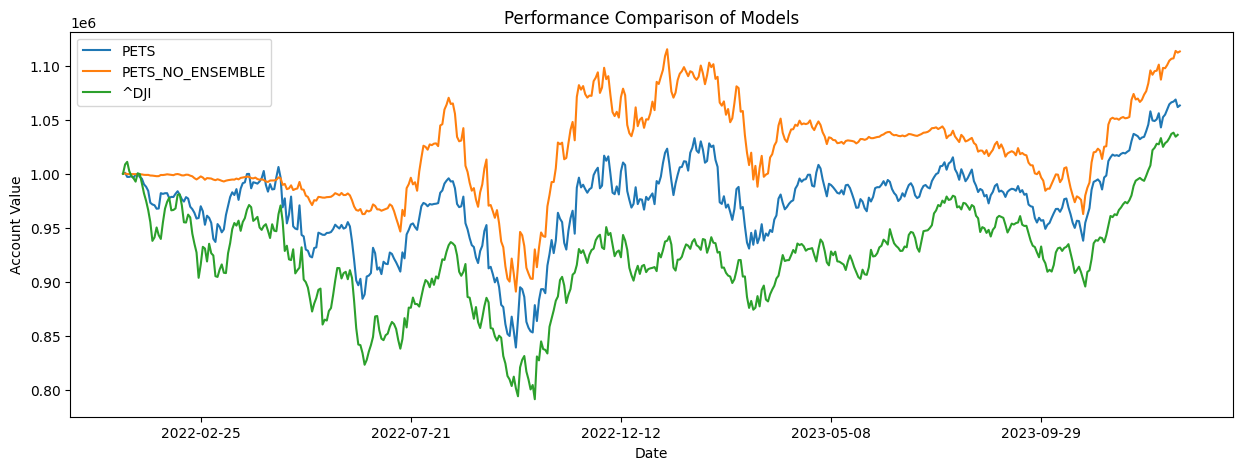

In [23]:
# Initialize DataFrame for account values
df_account_value = pd.DataFrame()

# Process account value data for each model
for model in model_names:
    for i in range(rebalance_window + validation_window, len(unique_trade_date) + 1, rebalance_window):
        file_name = f"results/account_value_trade_{model}_{i}.csv"
        temp = pd.read_csv(file_name)
        print(f"Reading account value data for {model} at {i}th trade date at {file_name}")
        temp['model'] = model
        df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
    sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
    print(f"Sharpe Ratio for {model}: {sharpe}")

# Map model names to DataFrames
model_account_values = {}
for model in model_names:
    model_account_values[model] = df_account_value[df_account_value['model'] == model].join(
        df_trade_date[validation_window:].reset_index(drop=True)
    )

# Save individual model results
for model, df_model in model_account_values.items():
    df_result = pd.DataFrame({'date': df_account_value['date'], model: df_model['account_value']})
    df_result = df_result.set_index('date')
    df_result.to_csv(f"df_result_{model.lower()}.csv")

# Baseline statistics
print("==============Get Baseline Stats===========")
df_dji_ = get_baseline(
    ticker="^DJI",
    start=df_account_value.loc[0, 'date'],
    end=df_account_value.loc[len(df_account_value) - 1, 'date']
)

stats = backtest_stats(df_dji_, value_col_name='close')

# Prepare DJI DataFrame
df_dji = pd.DataFrame()
df_dji['date'] = model_account_values['PETS']['date']  # Assuming 'ensemble' exists in model_names
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * env_kwargs["initial_amount"]

df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
df_dji.to_csv("df_dji+.csv")

# Save the combined account values
df_account_value.to_csv('df_account_value.csv')

# Combine results into a single DataFrame with consistent indexing
result = pd.DataFrame({'date': df_trade_date['datadate']})  # Use df_trade_date as the reference for dates
result = result.set_index('date')

# Merge each model's account value into the result DataFrame, aligning by date
for model, df_model in model_account_values.items():
    temp = pd.DataFrame({'date': df_model['date'], model: df_model['account_value']}).set_index('date')
    result = result.merge(temp, how='left', left_index=True, right_index=True)

# Add DJI to the results, aligning by date
df_dji_temp = df_dji.rename(columns={'dji': '^DJI'})
result = result.merge(df_dji_temp, how='left', left_index=True, right_index=True)

# Save the combined results
result.to_csv("result.csv")

# Plot the results
%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
result.plot()
plt.title("Performance Comparison of Models")
plt.ylabel("Account Value")
plt.xlabel("Date")
plt.show()


<Figure size 1500x500 with 0 Axes>

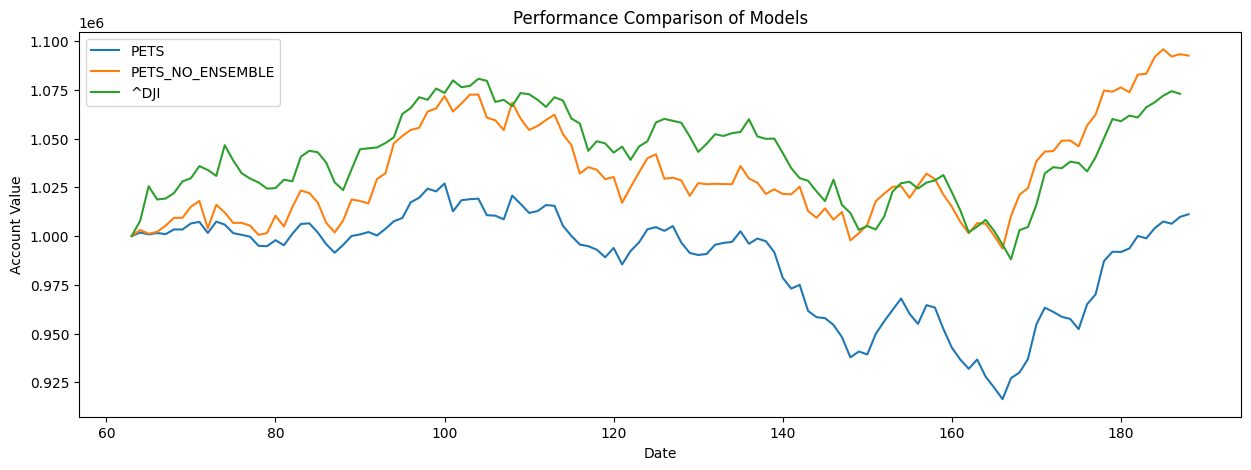

In [10]:
# load the results
result = pd.read_csv("ablation_result.csv")
plt.rcParams["figure.figsize"] = (15, 5)
plt.figure()
%matplotlib inline
result.plot()
plt.title("Performance Comparison of Models")
plt.ylabel("Account Value")
plt.xlabel("Date")
plt.show()